<a href="https://colab.research.google.com/github/zilavalencia/ChungaraVZila-IA-SIS420/blob/main/Laboratorios/Laboratorio08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LABORATORIO 8
# Desafío: Aprendizaje por Refuerzo en Brazo Robótico para Manipulación de Objetos



NOMBRE: Zila Chungara Valencia

CARRERA: Ingeniria de Sistemas


1. Entorno de Simulación (RobotArmEnvironment)

Brazo robótico: 3 articulaciones con cinemática directa
Espacio de trabajo: Circular de 1 metro de radio
Objeto: Vaso que se coloca aleatoriamente en el plano
Sensores: Información de posición, ángulos articulares y distancias
2. Espacio de Estados (14 dimensiones)

* Ángulos de las 3 articulaciones
* Velocidades angulares
* Posición del efector final (x, y)
* Posición del vaso (x, y)
* Vector de distancia al vaso
* Magnitud de la distancia
* Estado del vaso (volteado/no volteado)

3. Espacio de Acciones (4 dimensiones)

Velocidades angulares para las 3 articulaciones
Acción de empuje para voltear el vaso
4. Sistema de Recompensas

* Recompensa densa: Por proximidad al vaso
* Recompensa de éxito: +10 por voltear el vaso exitosamente
* Penalizaciones: Por salirse del espacio de trabajo, movimientos bruscos
* Eficiencia: Penalización pequeña por cada paso temporal




# Algoritmo PPO (Proximal Policy Optimization)
Red Actor-Critic

* Capas compartidas: Procesamiento de características del estado
* Actor: Genera política (media y desviación estándar de acciones)
* Critic: Estima función de valor del estado

# Características Avanzadas

* GAE (Generalized Advantage Estimation): Para estimación de ventajas más estable
* Clipping: Previene actualizaciones demasiado grandes
* Regularización por entropía: Mantiene exploración
* Gradient clipping: Estabiliza el entrenamiento

# Funcionalidades del Sistema

*Entrenamiento automatizado con métricas en tiempo real
* Visualización completa del brazo, vaso y espacio de trabajo
* Evaluación del agente entrenado
* Gráficos de análisis del progreso de aprendizaje
* Sistema de recompensas balanceado para aprendizaje eficiente

In [ ]:
# Opcional: Para GPU más rápida
import torch
print("GPU disponible:", torch.cuda.is_available())

GPU disponible: False


# 1. Instalaciones y Librerías Necesarias


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
from collections import deque
import random
import math

# 2. Entorno de Simulación del Brazo Robótico

simula un entorno de entrenamiento para un brazo robótico que debe aprender a empujar y voltear un vaso dentro de un espacio de trabajo.


In [ ]:

class RobotArmEnvironment:
    """
    Entorno de simulación para brazo robótico con manipulación de objetos
    """
    def __init__(self, workspace_size=1.0, max_steps=200):
        # Configuración del entorno
        self.workspace_size = workspace_size  # 1 metro de espacio de trabajo
        self.max_steps = max_steps
        self.current_step = 0

        # Configuración del brazo robótico (3 articulaciones)
        self.n_joints = 3
        self.joint_limits = np.array([[-np.pi, np.pi]] * self.n_joints)  # Límites angulares
        self.link_lengths = np.array([0.3, 0.25, 0.2])  # Longitudes de los eslabones

        # Estado del brazo
        self.joint_angles = np.zeros(self.n_joints)
        self.joint_velocities = np.zeros(self.n_joints)

        # Estado del vaso
        self.cup_position = np.zeros(2)  # (x, y) en el plano de trabajo
        self.cup_flipped = False
        self.cup_radius = 0.03  # Radio del vaso

        # Configuración de la cámara/sensores
        self.camera_resolution = (64, 64)  # Resolución de imagen simulada

        # Métricas de entrenamiento
        self.episode_reward = 0
        self.success_count = 0

        self.reset()

    def reset(self):
        """Reinicia el entorno para un nuevo episodio"""
        self.current_step = 0
        self.episode_reward = 0

        # Posición inicial del brazo (configuración neutra)
        self.joint_angles = np.random.uniform(-0.2, 0.2, self.n_joints)
        self.joint_velocities = np.zeros(self.n_joints)

        # Posición aleatoria del vaso en el espacio de trabajo
        angle = np.random.uniform(0, 2*np.pi)
        distance = np.random.uniform(0.2, 0.8)
        self.cup_position = np.array([
            distance * np.cos(angle),
            distance * np.sin(angle)
        ])
        self.cup_flipped = False

        return self._get_observation()

    def _forward_kinematics(self):
        """Calcula la posición del efector final usando cinemática directa"""
        x, y = 0, 0
        angle_sum = 0

        for i in range(self.n_joints):
            angle_sum += self.joint_angles[i]
            x += self.link_lengths[i] * np.cos(angle_sum)
            y += self.link_lengths[i] * np.sin(angle_sum)

        return np.array([x, y])

    def _get_observation(self):
        """Obtiene el estado actual del entorno"""
        end_effector_pos = self._forward_kinematics()

        # Vector de distancia al vaso
        distance_to_cup = self.cup_position - end_effector_pos
        distance_magnitude = np.linalg.norm(distance_to_cup)

        # Estado completo
        observation = np.concatenate([
            self.joint_angles,           # Ángulos de articulaciones (3)
            self.joint_velocities,       # Velocidades angulares (3)
            end_effector_pos,           # Posición del efector final (2)
            self.cup_position,          # Posición del vaso (2)
            distance_to_cup,            # Vector distancia (2)
            [distance_magnitude],       # Magnitud de distancia (1)
            [float(self.cup_flipped)]   # Estado del vaso (1)
        ])

        return observation.astype(np.float32)

    def step(self, action):
        """Ejecuta una acción en el entorno"""
        self.current_step += 1

        # Aplicar acciones (velocidades angulares de las articulaciones + acción de empuje)
        joint_velocities = action[:self.n_joints] * 0.1  # Escalar velocidades
        push_action = action[self.n_joints]  # Acción de empuje

        # Actualizar ángulos de articulaciones
        self.joint_velocities = joint_velocities
        self.joint_angles += joint_velocities * 0.1  # dt = 0.1

        # Aplicar límites angulares
        self.joint_angles = np.clip(self.joint_angles,
                                   self.joint_limits[:, 0],
                                   self.joint_limits[:, 1])

        # Calcular posición del efector final
        end_effector_pos = self._forward_kinematics()

        # Calcular recompensa
        reward = self._calculate_reward(end_effector_pos, push_action)

        # Verificar condiciones de finalización
        done = self._is_done(end_effector_pos)

        self.episode_reward += reward

        return self._get_observation(), reward, done, {}

    def _calculate_reward(self, end_effector_pos, push_action):
        """Calcula la recompensa basada en el estado actual"""
        reward = 0

        # Distancia al vaso
        distance_to_cup = np.linalg.norm(self.cup_position - end_effector_pos)

        # Recompensa por proximidad (recompensa densa)
        max_distance = np.sqrt(2) * self.workspace_size
        proximity_reward = 1.0 - (distance_to_cup / max_distance)
        reward += proximity_reward * 0.1

        # Recompensa por estar cerca del vaso
        if distance_to_cup < self.cup_radius * 2:
            reward += 1.0

            # Si está muy cerca y ejecuta acción de empuje
            if distance_to_cup < self.cup_radius * 1.5 and abs(push_action) > 0.5:
                if not self.cup_flipped:
                    self.cup_flipped = True
                    reward += 10.0  # Recompensa grande por voltear el vaso
                    self.success_count += 1

        # Penalización por salirse del espacio de trabajo
        if np.linalg.norm(end_effector_pos) > self.workspace_size:
            reward -= 2.0

        # Penalización por movimientos bruscos (suavidad)
        velocity_penalty = np.sum(np.abs(self.joint_velocities)) * 0.01
        reward -= velocity_penalty

        # Pequeña penalización por paso de tiempo (eficiencia)
        reward -= 0.01

        return reward

    def _is_done(self, end_effector_pos):
        """Verifica si el episodio ha terminado"""
        # Episodio termina si:
        # 1. El vaso fue volteado exitosamente
        # 2. Se alcanzó el límite máximo de pasos
        # 3. El brazo se salió completamente del espacio de trabajo

        return (self.cup_flipped or
                self.current_step >= self.max_steps or
                np.linalg.norm(end_effector_pos) > self.workspace_size * 1.5)

    def render(self):
        """Visualiza el estado actual del entorno"""
        plt.figure(figsize=(8, 8))

        # Dibujar espacio de trabajo
        circle = plt.Circle((0, 0), self.workspace_size, fill=False, linestyle='--', color='gray')
        plt.gca().add_patch(circle)

        # Dibujar brazo robótico
        x, y = 0, 0
        angle_sum = 0
        positions = [(x, y)]

        for i in range(self.n_joints):
            angle_sum += self.joint_angles[i]
            x += self.link_lengths[i] * np.cos(angle_sum)
            y += self.link_lengths[i] * np.sin(angle_sum)
            positions.append((x, y))

        # Dibujar eslabones
        for i in range(len(positions)-1):
            plt.plot([positions[i][0], positions[i+1][0]],
                    [positions[i][1], positions[i+1][1]], 'b-', linewidth=3)

        # Dibujar articulaciones
        for pos in positions:
            plt.plot(pos[0], pos[1], 'bo', markersize=8)

        # Dibujar efector final
        end_pos = positions[-1]
        plt.plot(end_pos[0], end_pos[1], 'ro', markersize=12, label='Efector Final')

        # Dibujar vaso
        cup_color = 'green' if self.cup_flipped else 'red'
        cup_circle = plt.Circle(self.cup_position, self.cup_radius, color=cup_color, alpha=0.7)
        plt.gca().add_patch(cup_circle)
        plt.plot(self.cup_position[0], self.cup_position[1], 'o', color=cup_color,
                markersize=10, label=f'Vaso {"(Volteado)" if self.cup_flipped else "(Normal)"}')

        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.legend()
        plt.title(f'Brazo Robótico - Paso {self.current_step} - Recompensa: {self.episode_reward:.2f}')
        plt.show()



**Modelo combinado:** Implementa una arquitectura Actor-Critic donde:

El Actor es el que decide qué acción tomar (política).

El Critic evalúa qué tan buena es la situación actual (función de valor).

**Arquitectura:**

Tiene una parte compartida de capas neuronales que procesa la entrada (el estado del entorno).

A partir de esa representación compartida, genera dos salidas separadas:

Una para el Actor que produce la media y desviación estándar (incertidumbre) de las acciones continuas que el agente puede tomar.

Otra para el Critic que estima un valor numérico de lo bueno que es el estado actual (valor esperado del retorno).

**Salida para el Actor:**

Genera una distribución probabilística (normal) de la cual se pueden muestrear acciones, lo que permite explorar el entorno.

In [ ]:

class ActorCritic(nn.Module):
    """
    Red neuronal Actor-Critic para PPO
    """
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(ActorCritic, self).__init__()

        # Capas compartidas
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU()
        )

        # Actor (política)
        self.actor_mean = nn.Linear(hidden_dim//2, action_dim)
        self.actor_std = nn.Parameter(torch.ones(action_dim) * 0.1)

        # Critic (función de valor)
        self.critic = nn.Linear(hidden_dim//2, 1)

    def forward(self, state):
        shared = self.shared_layers(state)

        # Actor output
        action_mean = torch.tanh(self.actor_mean(shared))  # Acciones entre -1 y 1
        action_std = F.softplus(self.actor_std) + 1e-5

        # Critic output
        value = self.critic(shared)

        return action_mean, action_std, value

    def get_action(self, state):
        action_mean, action_std, value = self.forward(state)
        dist = Normal(action_mean, action_std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)

        return action, log_prob, value

# Clase PPOAgent: el agente que aprende con PPO

Este conjunto de código implementa un ciclo típico de aprendizaje por refuerzo avanzado:

* Recolectar experiencias del entorno.

* Calcular ventajas para estimar qué tan buena fue cada acción.

* Actualizar la política para favorecer mejores acciones en el futuro.

* Evaluar el rendimiento para asegurarse que el agente mejora y puede cumplir la tarea.

 **1. Clase PPOAgent: el agente que aprende con PPO**
Esta clase representa el agente de aprendizaje por refuerzo que utiliza el algoritmo Proximal Policy Optimization (PPO) para aprender a actuar en un entorno, en este caso un brazo robótico.

**Componentes principales:**

Política actual (policy) y una copia antigua (policy_old) para hacer actualizaciones estables.

Un optimizador (Adam) para ajustar los pesos de la red neuronal.

Un buffer de memoria para almacenar las experiencias (estados, acciones, recompensas, etc.) durante el episodio antes de hacer la actualización.

Parámetros clave como la tasa de descuento (gamma), el valor para limitar el cambio en la política (eps_clip) y la cantidad de veces que se actualiza la política por ciclo (k_epochs).

**Funciones clave:**

store_transition: Guarda una experiencia (estado, acción, recompensa, etc.) para usarla luego en la actualización.

select_action: Usando la política antigua, selecciona una acción para un estado dado, junto con su probabilidad y el valor estimado.

compute_gae: Calcula la "ventaja" usando un método llamado Generalized Advantage Estimation (GAE), que ayuda a reducir la varianza en el entrenamiento y mejora la estabilidad.

update: Utiliza todas las experiencias almacenadas para actualizar la política y la función valor del agente usando el algoritmo PPO. Aquí se calcula la pérdida del actor (política) y del crítico (valor), se aplica el clipping para evitar grandes cambios, y se optimizan los parámetros de la red.



In [ ]:

class PPOAgent:
    """
    Agente PPO para el aprendizaje por refuerzo
    """
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, eps_clip=0.2, k_epochs=10):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs

        self.policy = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

        self.policy_old = ActorCritic(state_dim, action_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.mse_loss = nn.MSELoss()

        # Buffer para almacenar experiencias
        self.memory = {
            'states': [],
            'actions': [],
            'log_probs': [],
            'rewards': [],
            'dones': [],
            'values': []
        }

    def store_transition(self, state, action, log_prob, reward, done, value):
        self.memory['states'].append(state)
        self.memory['actions'].append(action)
        self.memory['log_probs'].append(log_prob)
        self.memory['rewards'].append(reward)
        self.memory['dones'].append(done)
        self.memory['values'].append(value)

    def select_action(self, state):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action, log_prob, value = self.policy_old.get_action(state_tensor)

        return action.squeeze().numpy(), log_prob.item(), value.item()

    def compute_gae(self, rewards, values, dones, next_value, lambda_gae=0.95):
        """Calcula Generalized Advantage Estimation"""
        advantages = []
        gae = 0

        values = values + [next_value]

        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * values[i+1] * (1-dones[i]) - values[i]
            gae = delta + self.gamma * lambda_gae * (1-dones[i]) * gae
            advantages.insert(0, gae)

        return advantages

    def update(self):
        # Convert lists to tensors
        states = torch.FloatTensor(np.array(self.memory['states']))
        actions = torch.FloatTensor(np.array(self.memory['actions']))
        old_log_probs = torch.FloatTensor(self.memory['log_probs'])
        rewards = self.memory['rewards']
        dones = self.memory['dones']
        values = self.memory['values']

        # Compute advantages using GAE
        next_value = 0  # Asumimos que el último estado es terminal
        advantages = self.compute_gae(rewards, values, dones, next_value)
        advantages = torch.FloatTensor(advantages)

        # Compute returns
        returns = advantages + torch.FloatTensor(values)

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update
        for _ in range(self.k_epochs):
            # Get current policy outputs
            action_means, action_stds, state_values = self.policy(states)
            dist = Normal(action_means, action_stds)
            new_log_probs = dist.log_prob(actions).sum(dim=-1)
            entropy = dist.entropy().sum(dim=-1)

            # Ratio for clipping
            ratio = torch.exp(new_log_probs - old_log_probs)

            # Actor loss
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()

            # Critic loss
            critic_loss = self.mse_loss(state_values.squeeze(), returns)

            # Total loss
            total_loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy.mean()

            # Update
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

        # Update old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Clear memory
        for key in self.memory:
            self.memory[key] = []

        return actor_loss.item(), critic_loss.item()


def train_robot_arm(episodes=2000, update_interval=20):
    """
    Función principal de entrenamiento
    """
    # Crear entorno y agente
    env = RobotArmEnvironment()
    state_dim = len(env.reset())
    action_dim = env.n_joints + 1  # 3 articulaciones + 1 acción de empuje

    agent = PPOAgent(state_dim, action_dim)

    # Métricas de entrenamiento
    episode_rewards = []
    success_rates = []
    losses = []

    print("Iniciando entrenamiento del brazo robótico...")
    print(f"Dimensión del estado: {state_dim}")
    print(f"Dimensión de la acción: {action_dim}")

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0

        while True:
            # Seleccionar acción
            action, log_prob, value = agent.select_action(state)

            # Ejecutar acción
            next_state, reward, done, _ = env.step(action)

            # Almacenar transición
            agent.store_transition(state, action, log_prob, reward, done, value)

            state = next_state
            episode_reward += reward

            if done:
                break

        episode_rewards.append(episode_reward)

        # Actualizar política
        if (episode + 1) % update_interval == 0:
            actor_loss, critic_loss = agent.update()
            losses.append((actor_loss, critic_loss))

            # Calcular tasa de éxito
            recent_episodes = episode_rewards[-update_interval:]
            success_count = sum(1 for r in recent_episodes if r > 5)  # Umbral de éxito
            success_rate = success_count / len(recent_episodes)
            success_rates.append(success_rate)

            print(f"Episodio {episode+1}/{episodes}")
            print(f"  Recompensa promedio: {np.mean(recent_episodes):.2f}")
            print(f"  Tasa de éxito: {success_rate:.2%}")
            print(f"  Actor Loss: {actor_loss:.4f}, Critic Loss: {critic_loss:.4f}")
            print("-" * 50)

    return agent, episode_rewards, success_rates, losses


def evaluate_agent(agent, env, episodes=10):
    """
    Evalúa el agente entrenado
    """
    total_rewards = []
    successes = 0

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0

        while True:
            action, _, _ = agent.select_action(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                if env.cup_flipped:
                    successes += 1
                break

        total_rewards.append(episode_reward)
        print(f"Episodio {episode+1}: Recompensa = {episode_reward:.2f}, "
              f"Éxito = {'Sí' if env.cup_flipped else 'No'}")

    print(f"\nResultados de evaluación:")
    print(f"Recompensa promedio: {np.mean(total_rewards):.2f}")
    print(f"Tasa de éxito: {successes/episodes:.2%}")

    return total_rewards, successes/episodes



# 3. Modelo de Red Neuronal Actor-Critic (Base para PPO)

La red tiene dos funciones principales que se ejecutan juntas:

* Actor (política): Decide qué acción tomar en un estado dado. En vez de dar una acción fija, produce una distribución probabilística (media y desviación estándar) para muestrear acciones, lo que facilita explorar diferentes acciones.

* Critic (función valor): Evalúa qué tan bueno es el estado actual, prediciendo el valor esperado de recompensa futura desde ese estado.


In [ ]:

class ActorCritic(nn.Module):
    """
    Red neuronal Actor-Critic para PPO
    """
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(ActorCritic, self).__init__()

        # Capas compartidas
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU()
        )

        # Actor (política)
        self.actor_mean = nn.Linear(hidden_dim//2, action_dim)
        self.actor_std = nn.Parameter(torch.ones(action_dim) * 0.1)

        # Critic (función de valor)
        self.critic = nn.Linear(hidden_dim//2, 1)

    def forward(self, state):
        shared = self.shared_layers(state)

        # Actor output
        action_mean = torch.tanh(self.actor_mean(shared))  # Acciones entre -1 y 1
        action_std = F.softplus(self.actor_std) + 1e-5

        # Critic output
        value = self.critic(shared)

        return action_mean, action_std, value

    def get_action(self, state):
        action_mean, action_std, value = self.forward(state)
        dist = Normal(action_mean, action_std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)

        return action, log_prob, value


# Visualizaciones de los resultados

In [ ]:

def plot_training_results(episode_rewards, success_rates):
    """
    Visualiza los resultados del entrenamiento
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Recompensas por episodio
    ax1.plot(episode_rewards, alpha=0.6)
    ax1.plot([i*20 for i in range(len(success_rates))],
             [np.mean(episode_rewards[max(0, i*20-20):i*20+1]) for i in range(len(success_rates))],
             'r-', linewidth=2, label='Media móvil')
    ax1.set_xlabel('Episodio')
    ax1.set_ylabel('Recompensa')
    ax1.set_title('Recompensas durante el entrenamiento')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Tasa de éxito
    ax2.plot([i*20 for i in range(len(success_rates))],
             [rate*100 for rate in success_rates], 'g-', linewidth=2)
    ax2.set_xlabel('Episodio')
    ax2.set_ylabel('Tasa de éxito (%)')
    ax2.set_title('Tasa de éxito durante el entrenamiento')
    ax2.grid(True, alpha=0.3)

    # Distribución de recompensas
    ax3.hist(episode_rewards, bins=50, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Recompensa')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de recompensas')
    ax3.grid(True, alpha=0.3)

    # Progreso de aprendizaje
    window_size = 100
    if len(episode_rewards) >= window_size:
        moving_avg = [np.mean(episode_rewards[max(0, i-window_size):i+1])
                     for i in range(len(episode_rewards))]
        ax4.plot(moving_avg, 'b-', linewidth=2)
        ax4.set_xlabel('Episodio')
        ax4.set_ylabel('Recompensa media móvil')
        ax4.set_title(f'Progreso de aprendizaje (ventana de {window_size})')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# EJEMPLO DE USO

=== ENTRENAMIENTO DEL BRAZO ROBÓTICO ===
Iniciando entrenamiento del brazo robótico...
Dimensión del estado: 14
Dimensión de la acción: 4
Episodio 20/1000
  Recompensa promedio: 5.97
  Tasa de éxito: 45.00%
  Actor Loss: -0.0030, Critic Loss: 0.2591
--------------------------------------------------
Episodio 40/1000
  Recompensa promedio: 7.80
  Tasa de éxito: 70.00%
  Actor Loss: -0.0030, Critic Loss: 0.2847
--------------------------------------------------
Episodio 60/1000
  Recompensa promedio: 4.60
  Tasa de éxito: 45.00%
  Actor Loss: -0.0031, Critic Loss: 0.1791
--------------------------------------------------
Episodio 80/1000
  Recompensa promedio: 4.04
  Tasa de éxito: 40.00%
  Actor Loss: -0.0018, Critic Loss: 0.0690
--------------------------------------------------
Episodio 100/1000
  Recompensa promedio: 5.32
  Tasa de éxito: 50.00%
  Actor Loss: -0.0024, Critic Loss: 0.0826
--------------------------------------------------
Episodio 120/1000
  Recompensa promedio: 7.42


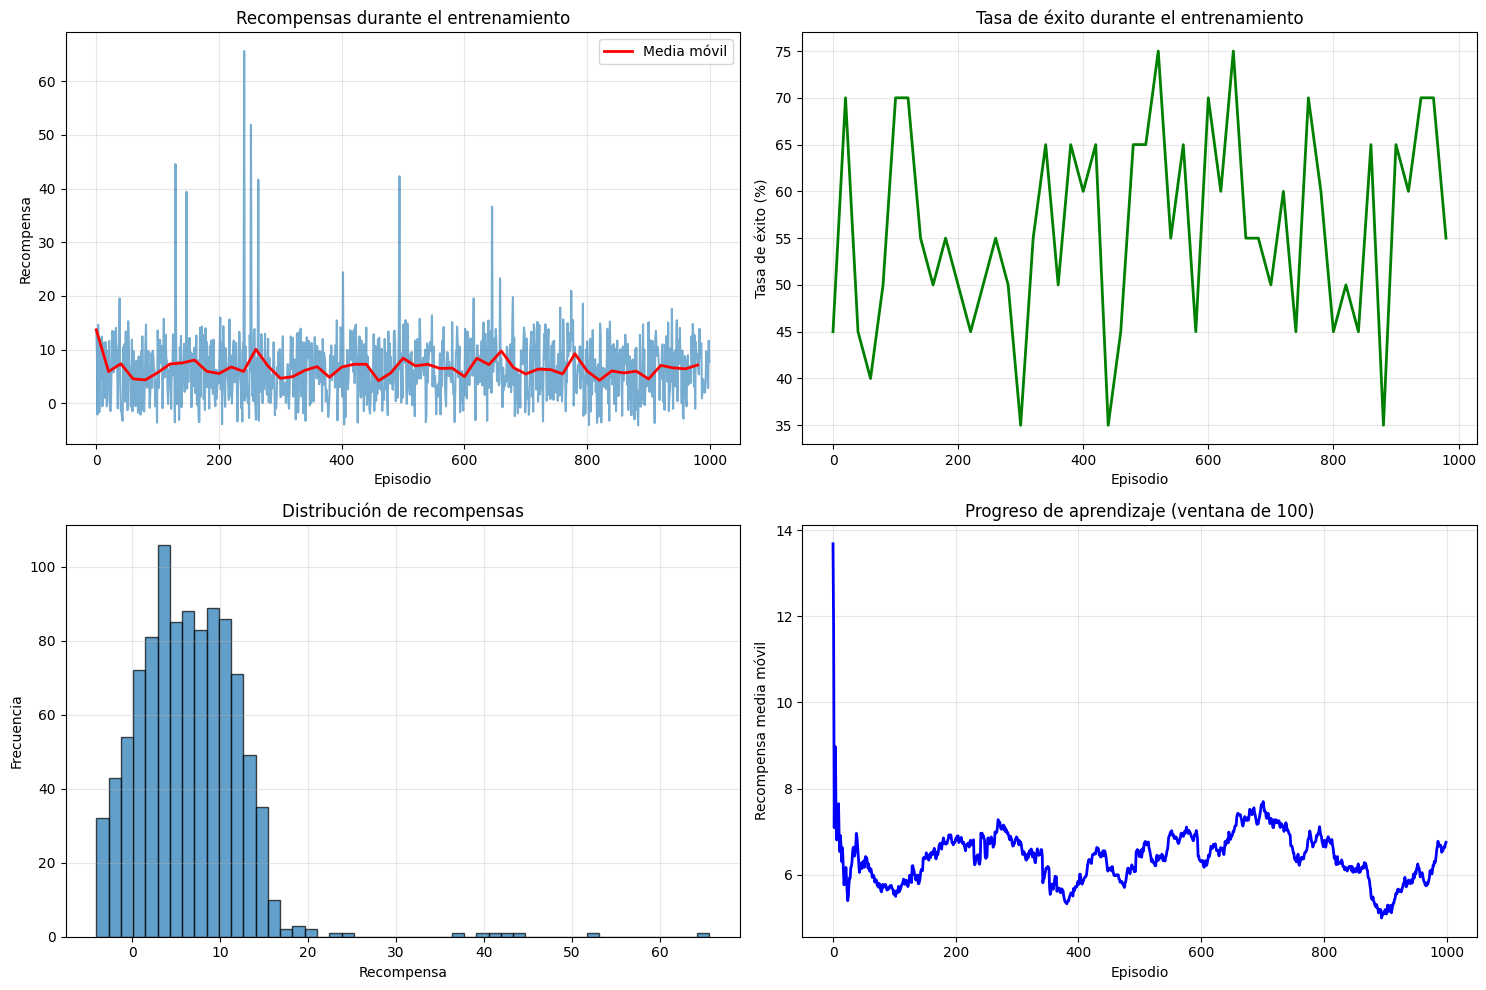


=== EVALUACIÓN DEL AGENTE ENTRENADO ===
Episodio 1: Recompensa = 4.13, Éxito = No
Episodio 2: Recompensa = 7.82, Éxito = No
Episodio 3: Recompensa = 14.14, Éxito = No
Episodio 4: Recompensa = 8.24, Éxito = No
Episodio 5: Recompensa = 1.30, Éxito = No
Episodio 6: Recompensa = 5.12, Éxito = No
Episodio 7: Recompensa = 3.49, Éxito = No
Episodio 8: Recompensa = 3.52, Éxito = No
Episodio 9: Recompensa = 6.98, Éxito = No
Episodio 10: Recompensa = 4.28, Éxito = No

Resultados de evaluación:
Recompensa promedio: 5.90
Tasa de éxito: 0.00%

=== DEMOSTRACIÓN VISUAL ===


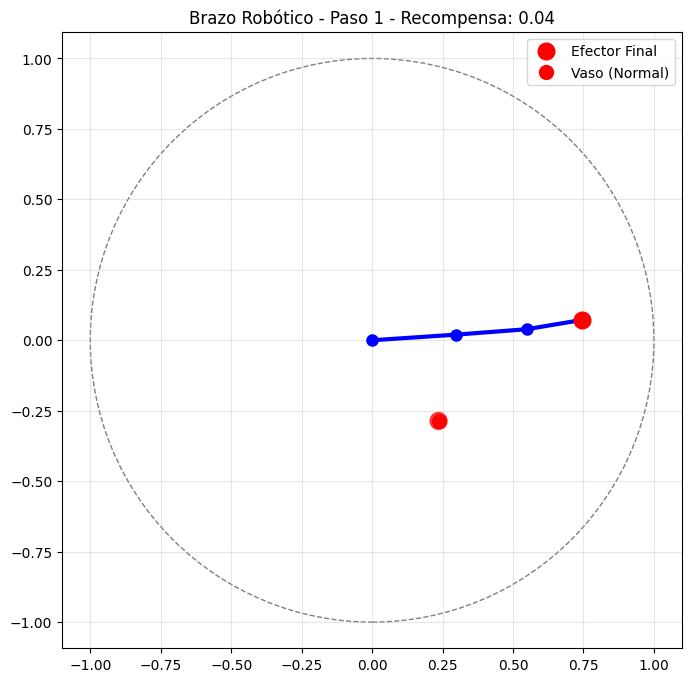

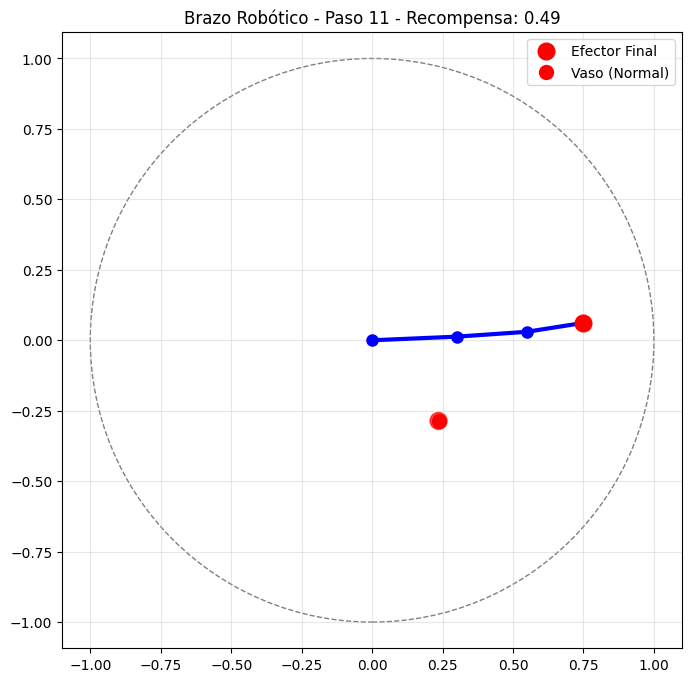

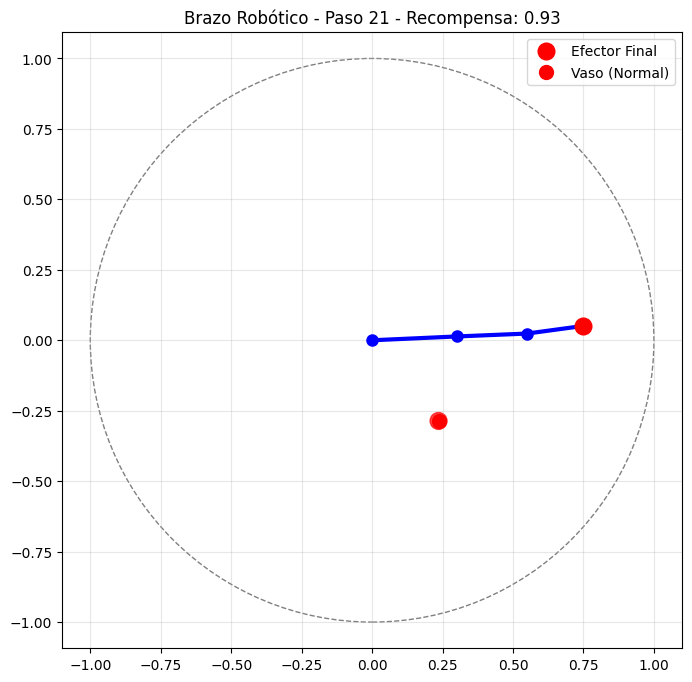

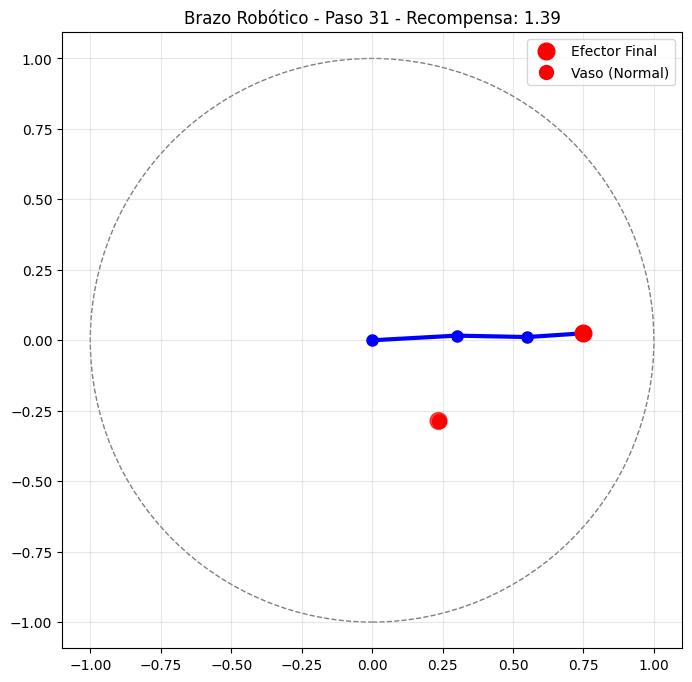

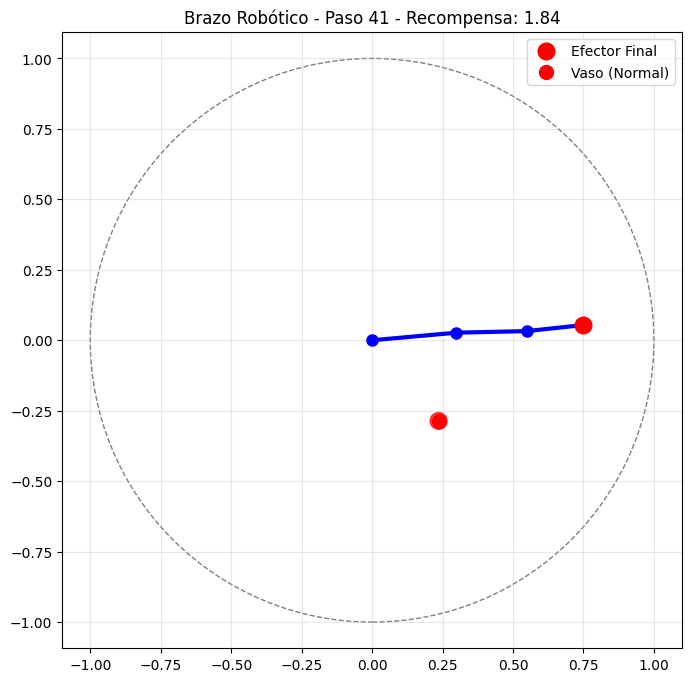

In [ ]:
# Ejemplo de uso
if __name__ == "__main__":
    # Entrenamiento
    print("=== ENTRENAMIENTO DEL BRAZO ROBÓTICO ===")
    agent, rewards, success_rates, losses = train_robot_arm(episodes=1000, update_interval=20)

    # Visualizar resultados
    plot_training_results(rewards, success_rates)

    # Evaluación
    print("\n=== EVALUACIÓN DEL AGENTE ENTRENADO ===")
    env = RobotArmEnvironment()
    eval_rewards, success_rate = evaluate_agent(agent, env, episodes=10)

    # Demostración visual
    print("\n=== DEMOSTRACIÓN VISUAL ===")
    state = env.reset()
    for step in range(50):  # Máximo 50 pasos para la demo
        action, _, _ = agent.select_action(state)
        state, reward, done, _ = env.step(action)

        if step % 10 == 0:  # Mostrar cada 10 pasos
            env.render()

        if done:
            print(f"Episodio terminado en el paso {step+1}")
            print(f"¿Vaso volteado? {'Sí' if env.cup_flipped else 'No'}")
            env.render()  # Mostrar estado final
            break